# 🔍 Search Within and Image

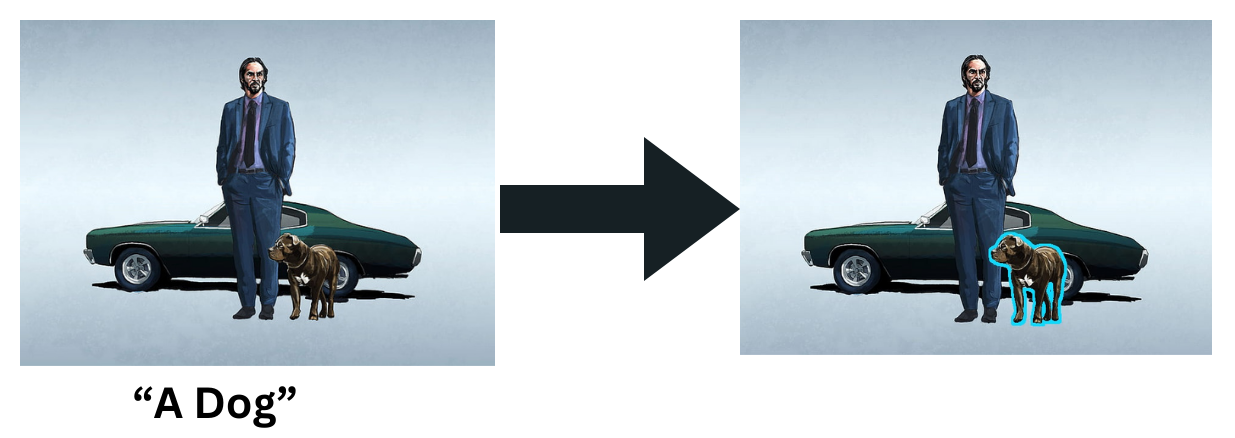
### Leveraging the SAM and CLIP models, we employ natural language queries to seamlessly segment, crop, and pinpoint the nearest match for an object.

### Installing dependencies

In [1]:
# install all the neccessary libraries
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install open_clip_torch
!pip install lancedb

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-2fwtu0fi
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-2fwtu0fi
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=7bcd600b68024d6961c11ce285ba75b81f7511d45614fae681d1575b88060669
  Stored in directory: /tmp/pip-ephem-wheel-cache-saey51gc/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Import libraries

In [36]:
# making all the imports, for a cleaner code structure
import cv2
import lancedb
import matplotlib.pyplot as plt
import numpy as np
import open_clip
import os
from PIL import Image, Image as PIL_Img
import pandas as pd
import requests
import torch
import uuid
from IPython.display import Image, display

### Load SAM weights

In [2]:
# load the weights for SAM, using ViT-H model
url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
response = requests.get(url)

with open("sam_vit_h_4b8939.pth", "wb") as f:
    f.write(response.content)

### Initialize database

In [3]:
# initialize the database
uri = "data/sample-lancedb"
db = lancedb.connect(uri)

### Load model

In [4]:
# load the CLIP model, ViT-B-32
model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="laion2b_s34b_b79k"
)
tokenizer = open_clip.get_tokenizer("ViT-B-32")
model.eval()

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

### Image embeddings

In [23]:
# function to get the image embeddings
def get_image_embeddings_from_path(file_path):
    # Load the image from the file path
    image = preprocess(Image.open(file_path)).unsqueeze(0)
    # Encode the image
    with torch.no_grad():
        embeddings = model.encode_image(image)
    embeddings = embeddings.squeeze()  # to squeeze the embeddings into 1-dimension
    return embeddings.detach().numpy()

In [6]:
# utility function to download image, given the link
def download_image(url):
    response = requests.get(url)
    img_dir = uuid.uuid4().hex[:6]
    os.makedirs(img_dir)
    file_path = img_dir + "/" + "index" + ".jpg"
    with open(file_path, "wb") as f:
        f.write(response.content)
    return img_dir

In [39]:
# load SAM
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")


# extract the segmentation masks from the image
def get_image_segmentations(img_path):
    input_img = cv2.imread(img_path)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(input_img)
    return masks

### Create images from new segmentation masks

In [8]:
# crop the into segmentation masks, and create new images
def crop_image_by_seg(image, segmentation):
    """
    Input:
        image: np.array,
        segmentation : np.array

    """
    binary_mask = segmentation.astype(int)

    # Create a white canvas of the same size as the image
    white_canvas = np.ones_like(image) * 255

    # Apply the binary mask to the original image and white canvas
    cropped_image = np.where(binary_mask[..., None] > 0, image, white_canvas)
    return cropped_image

In [9]:
# utility function to crop the image using bounding boxes
def crop_image_with_bbox(image, bbox):
    X, Y, W, H = bbox
    cropped_image = image[Y : Y + H, X : X + W]

    return cropped_image

### Composite function to call all functionalities

In [10]:
# composite call to the functions to create the segmentation mask, crop it, embed it and finally index it into LanceDB
def index_images_to_lancedb(img_uuid):
    img_path = img_uuid + "/index.jpg"
    source_img = cv2.imread(img_path)
    segmentations = get_image_segmentations(img_path)  # get the segmentations

    for index, seg in enumerate(segmentations):
        cropped_img = crop_image_with_bbox(
            crop_image_by_seg(source_img, seg["segmentation"]), seg["bbox"]
        )  # crop the image by bbox
        c_img_path = img_uuid + "/{}.jpg".format(index)
        cv2.imwrite(c_img_path, cropped_img)
        embeddings = get_image_embeddings_from_path(
            c_img_path
        )  # embed the image using CLIP
        seg["embeddings"] = embeddings
        seg["img_path"] = c_img_path
        seg["seg_shape"] = seg["segmentation"].shape
        seg["segmentation"] = seg["segmentation"].reshape(-1)

    seg_df = pd.DataFrame(segmentations)
    seg_df = seg_df[
        [
            "img_path",
            "embeddings",
            "bbox",
            "stability_score",
            "predicted_iou",
            "segmentation",
            "seg_shape",
        ]
    ]
    seg_df = seg_df.rename(columns={"embeddings": "vector"})
    tbl = db.create_table(
        "table_{}".format(img_uuid), data=seg_df
    )  # index the images into table
    return tbl

In [ ]:
# flatten the list
def flatten_list(lst):
    return [item for sublist in lst for item in sublist]

### Query the database using Natural Query

In [34]:
# find the image using natural language query
def search_image_with_user_query(vector_table, img_id, user_query):
    text = tokenizer(user_query)
    k_embedding = model.encode_text(text).tolist()  # Use tolist() instead of to_list()
    # Flatten k_embedding to a List[float]
    k_embedding_list = flatten_list(k_embedding)

    target = vector_table.search(k_embedding_list).limit(1).to_pandas()
    segmentation_mask = cv2.convertScaleAbs(
        target.iloc[0]["segmentation"].reshape(target.iloc[0]["seg_shape"]).astype(int)
    )

    # Dilate the segmentation mask to expand the area
    dilated_mask = cv2.dilate(
        segmentation_mask, np.ones((10, 10), np.uint8), iterations=1
    )

    # Create a mask of the surroundings by subtracting the original segmentation mask
    surroundings_mask = dilated_mask - segmentation_mask

    # Create a highlighted version of the original image
    path = "{}/index.jpg".format(img_id)
    highlighted_image = cv2.imread(path)
    highlighted_image[surroundings_mask > 0] = [253, 218, 13]

    cv2.imwrite("{}/processed.jpg".format(img_id), highlighted_image)

    # Display the image
    display(Image(filename="{}/processed.jpg".format(img_id)))

In [12]:
url = "https://w0.peakpx.com/wallpaper/600/440/HD-wallpaper-john-wick-with-mustang.jpg"
img_uuid = download_image(url)

In [13]:
print(img_uuid)

079698


In [24]:
tbl = index_images_to_lancedb(img_uuid)

### Search within Image

<ipython-input-34-9e56bc3147b0>:15: DeprecatedWarning: to_df is deprecated as of 0.3.1 and will be removed in 0.4.0. Use to_pandas() instead
  target = vector_table.search(k_embedding_list).limit(1).to_df()


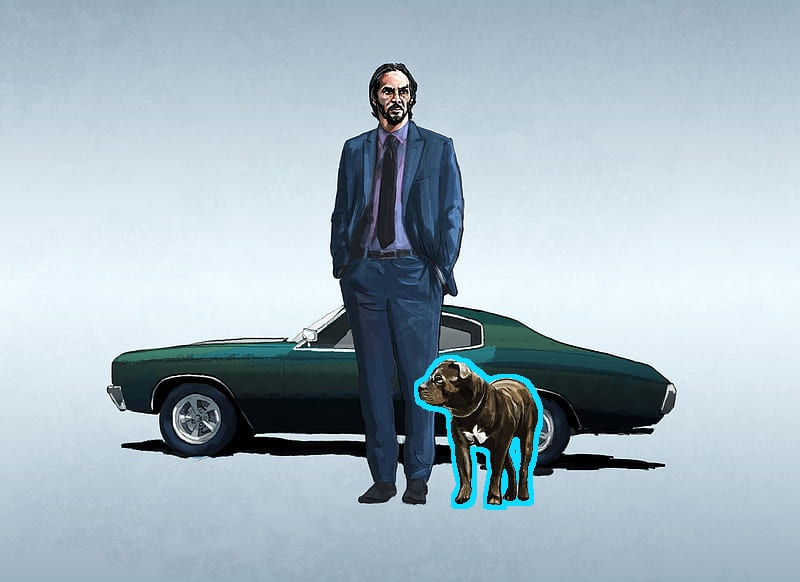

In [35]:
search_image_with_user_query(tbl, img_uuid, "a dog")

# Display the Segmentation Masks (Optional)

In [44]:
# load the image
img_path = "/content/079698/index.jpg"
ans = get_image_segmentations(img_path)

Segmentation 1 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 41611
 - Bounding Box: [107, 306, 568, 159]
 - Predicted IOU: 1.0235613584518433
 - Point Coordinates: [[237.5, 391.03125]]
 - Stability Score: 0.9665665626525879
 - Crop Box: [0, 0, 800, 582]



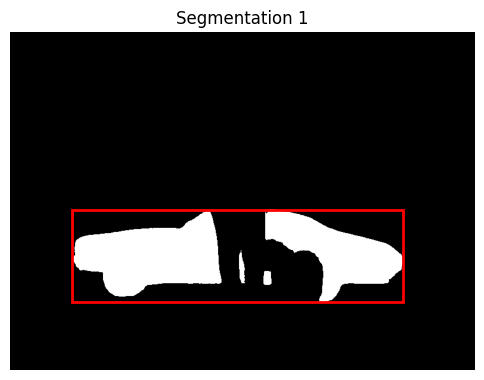

Segmentation 2 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 41712
 - Bounding Box: [107, 142, 568, 322]
 - Predicted IOU: 1.0185126066207886
 - Point Coordinates: [[112.5, 372.84375]]
 - Stability Score: 0.962044358253479
 - Crop Box: [0, 0, 800, 582]



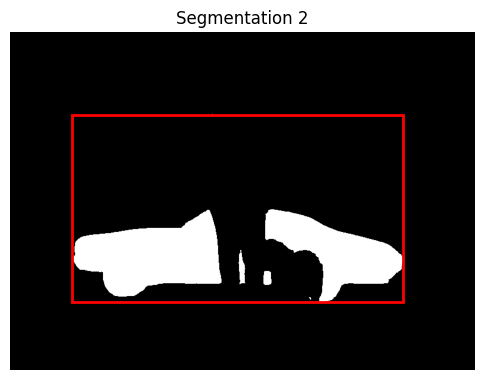

Segmentation 3 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 36694
 - Bounding Box: [331, 64, 132, 439]
 - Predicted IOU: 1.0150949954986572
 - Point Coordinates: [[362.5, 245.53125]]
 - Stability Score: 0.9721011519432068
 - Crop Box: [0, 0, 800, 582]



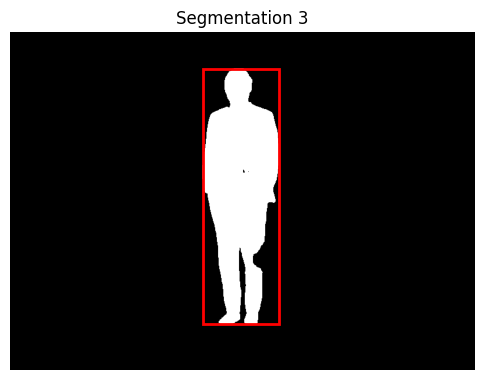

Segmentation 4 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ...  True  True  True]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 365699
 - Bounding Box: [0, 2, 799, 577]
 - Predicted IOU: 1.0133819580078125
 - Point Coordinates: [[712.5, 9.09375]]
 - Stability Score: 0.988547146320343
 - Crop Box: [0, 0, 800, 582]



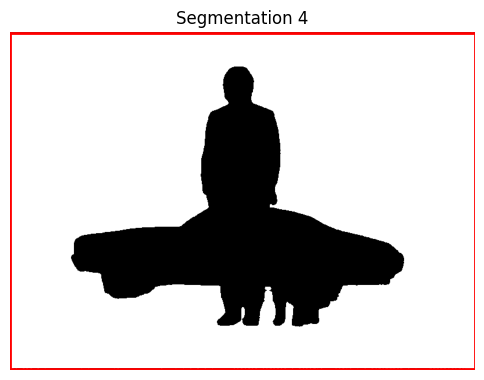

Segmentation 5 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 4585
 - Bounding Box: [160, 383, 77, 72]
 - Predicted IOU: 1.0104466676712036
 - Point Coordinates: [[187.5, 409.21875]]
 - Stability Score: 0.9850842952728271
 - Crop Box: [0, 0, 800, 582]



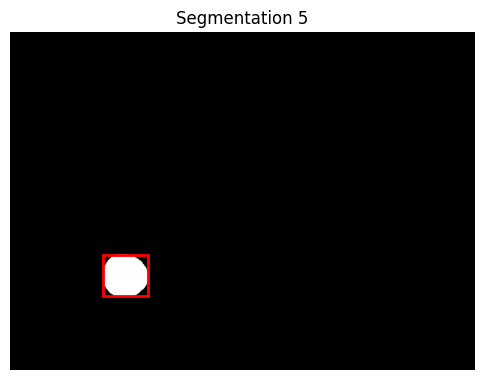

Segmentation 6 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 9504
 - Bounding Box: [418, 359, 119, 145]
 - Predicted IOU: 1.0063835382461548
 - Point Coordinates: [[462.5, 427.40625]]
 - Stability Score: 0.9682473540306091
 - Crop Box: [0, 0, 800, 582]



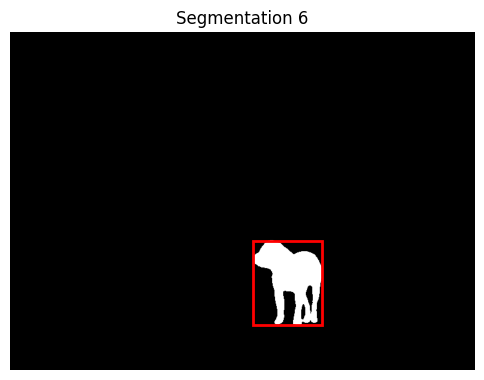

Segmentation 7 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [ True  True  True ...  True  True False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 250489
 - Bounding Box: [0, 2, 799, 390]
 - Predicted IOU: 1.0047119855880737
 - Point Coordinates: [[462.5, 245.53125]]
 - Stability Score: 0.9785979986190796
 - Crop Box: [0, 0, 800, 582]



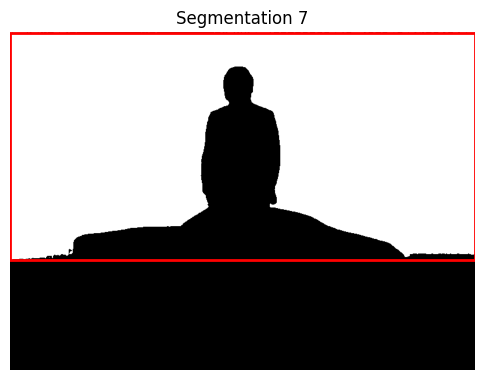

Segmentation 8 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 1996
 - Bounding Box: [172, 394, 48, 50]
 - Predicted IOU: 1.0041521787643433
 - Point Coordinates: [[212.5, 409.21875]]
 - Stability Score: 0.991008996963501
 - Crop Box: [0, 0, 800, 582]



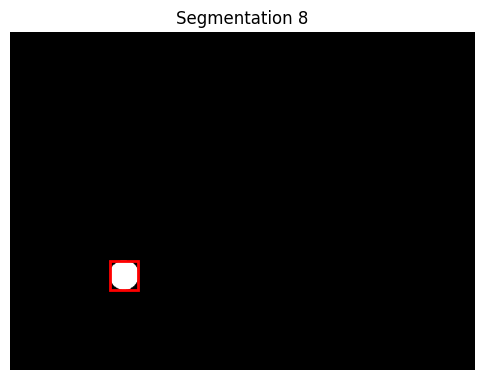

Segmentation 9 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 113716
 - Bounding Box: [0, 392, 799, 187]
 - Predicted IOU: 1.0034291744232178
 - Point Coordinates: [[137.5, 427.40625]]
 - Stability Score: 0.9641968011856079
 - Crop Box: [0, 0, 800, 582]



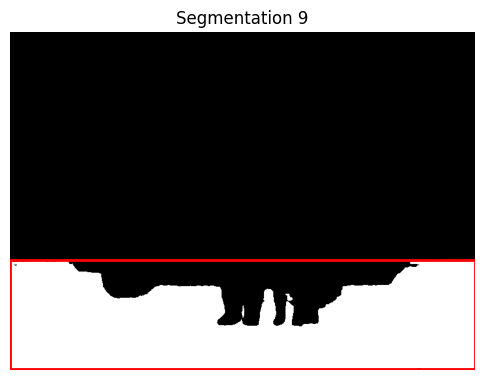

Segmentation 10 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 16281
 - Bounding Box: [340, 256, 101, 226]
 - Predicted IOU: 1.0015268325805664
 - Point Coordinates: [[362.5, 372.84375]]
 - Stability Score: 0.9821080565452576
 - Crop Box: [0, 0, 800, 582]



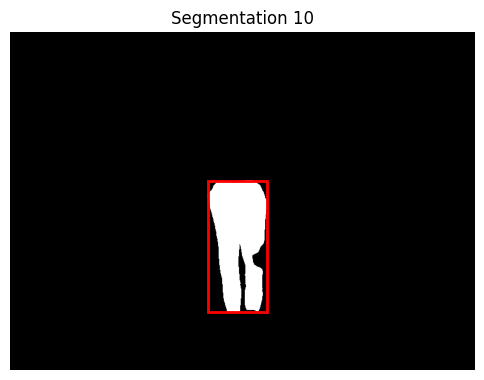

Segmentation 11 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 12259
 - Bounding Box: [330, 120, 133, 175]
 - Predicted IOU: 0.9962115287780762
 - Point Coordinates: [[462.5, 190.96875]]
 - Stability Score: 0.9634341597557068
 - Crop Box: [0, 0, 800, 582]



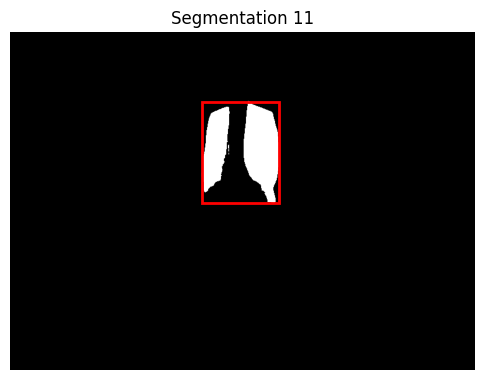

Segmentation 12 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 2184
 - Bounding Box: [509, 396, 61, 69]
 - Predicted IOU: 0.9904167652130127
 - Point Coordinates: [[537.5, 427.40625]]
 - Stability Score: 0.9650537371635437
 - Crop Box: [0, 0, 800, 582]



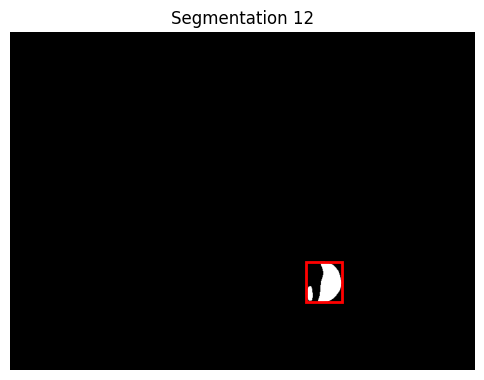

Segmentation 13 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 622
 - Bounding Box: [358, 482, 38, 21]
 - Predicted IOU: 0.9883782267570496
 - Point Coordinates: [[387.5, 500.15625]]
 - Stability Score: 0.9935794472694397
 - Crop Box: [0, 0, 800, 582]



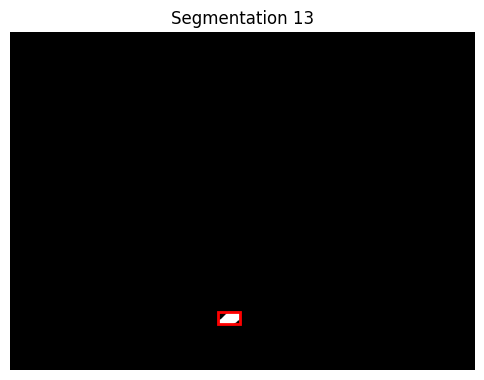

Segmentation 14 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 560
 - Bounding Box: [402, 478, 25, 26]
 - Predicted IOU: 0.9865313172340393
 - Point Coordinates: [[412.5, 481.96875]]
 - Stability Score: 0.9822379946708679
 - Crop Box: [0, 0, 800, 582]



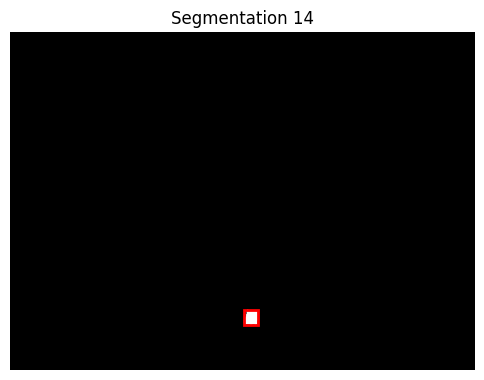

Segmentation 15 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 361
 - Bounding Box: [660, 383, 16, 31]
 - Predicted IOU: 0.9778174161911011
 - Point Coordinates: [[662.5, 409.21875]]
 - Stability Score: 0.9863013625144958
 - Crop Box: [0, 0, 800, 582]



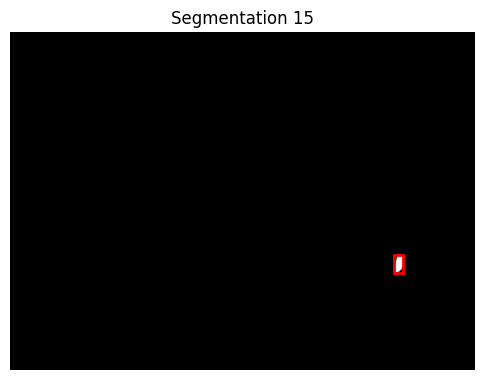

Segmentation 16 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 326
 - Bounding Box: [106, 385, 20, 25]
 - Predicted IOU: 0.9736118316650391
 - Point Coordinates: [[112.5, 391.03125]]
 - Stability Score: 0.9878787994384766
 - Crop Box: [0, 0, 800, 582]



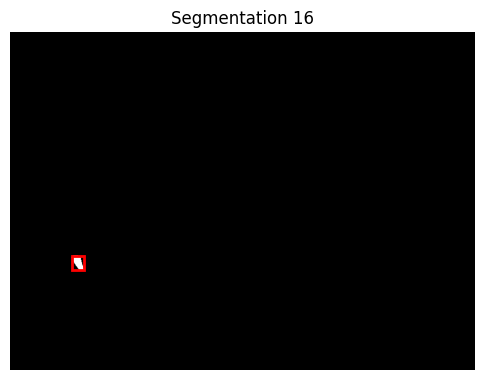

Segmentation 17 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 1781
 - Bounding Box: [376, 135, 22, 113]
 - Predicted IOU: 0.966787576675415
 - Point Coordinates: [[387.5, 172.78125]]
 - Stability Score: 0.972421407699585
 - Crop Box: [0, 0, 800, 582]



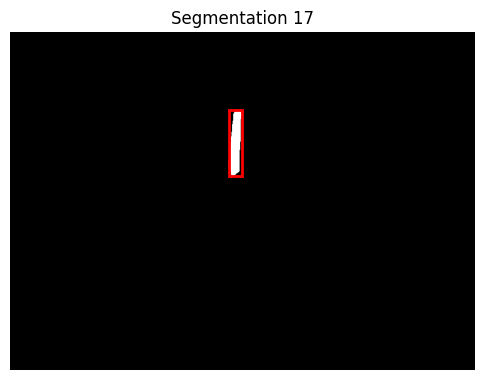

Segmentation 18 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 1149
 - Bounding Box: [358, 479, 69, 25]
 - Predicted IOU: 0.9562665224075317
 - Point Coordinates: [[362.5, 500.15625]]
 - Stability Score: 0.9666666388511658
 - Crop Box: [0, 0, 800, 582]



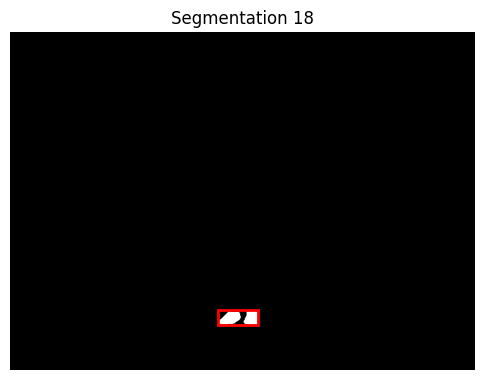

Segmentation 19 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 688
 - Bounding Box: [533, 407, 20, 46]
 - Predicted IOU: 0.9507281184196472
 - Point Coordinates: [[537.5, 427.40625]]
 - Stability Score: 0.9715505242347717
 - Crop Box: [0, 0, 800, 582]



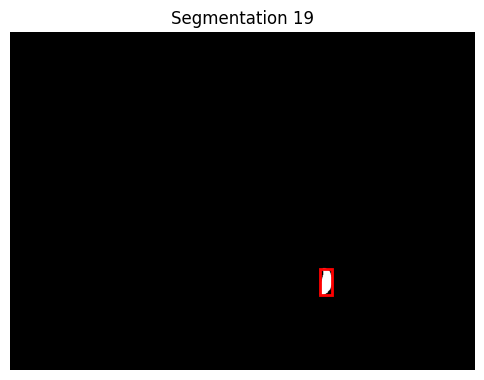

Segmentation 20 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 1329
 - Bounding Box: [544, 454, 120, 15]
 - Predicted IOU: 0.9482901692390442
 - Point Coordinates: [[562.5, 463.78125]]
 - Stability Score: 0.9732142686843872
 - Crop Box: [0, 0, 800, 582]



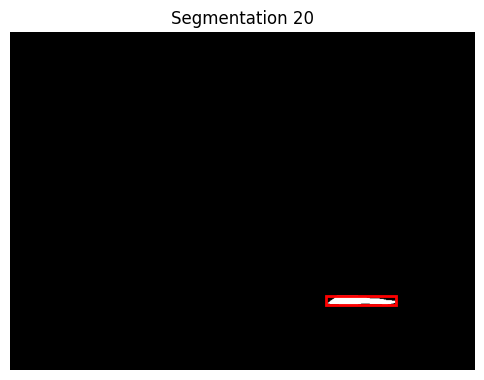

Segmentation 21 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 1707
 - Bounding Box: [374, 71, 36, 61]
 - Predicted IOU: 0.9459723234176636
 - Point Coordinates: [[387.5, 118.21875]]
 - Stability Score: 0.967797577381134
 - Crop Box: [0, 0, 800, 582]



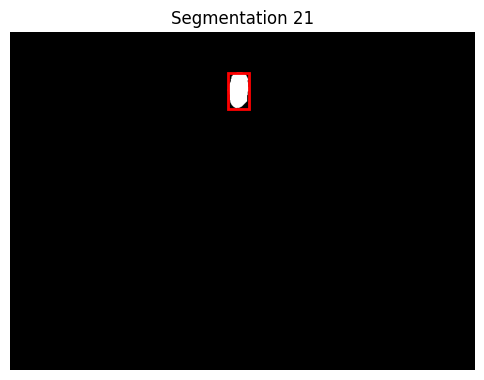

Segmentation 22 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 911
 - Bounding Box: [369, 63, 48, 54]
 - Predicted IOU: 0.9456807971000671
 - Point Coordinates: [[412.5, 81.84375]]
 - Stability Score: 0.9581095576286316
 - Crop Box: [0, 0, 800, 582]



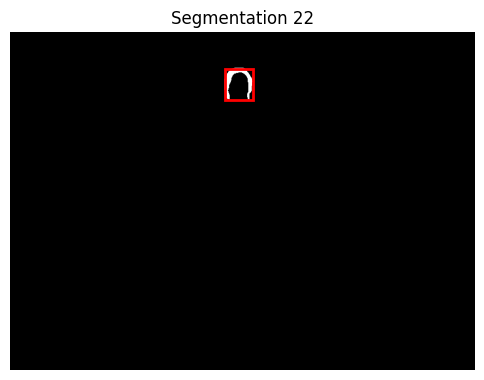

Segmentation 23 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 1359
 - Bounding Box: [439, 313, 43, 38]
 - Predicted IOU: 0.93308025598526
 - Point Coordinates: [[462.5, 318.28125]]
 - Stability Score: 0.9680927991867065
 - Crop Box: [0, 0, 800, 582]



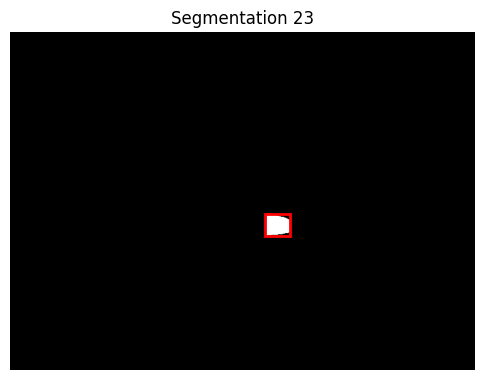

Segmentation 24 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 647
 - Bounding Box: [439, 324, 32, 25]
 - Predicted IOU: 0.9214211106300354
 - Point Coordinates: [[462.5, 336.46875]]
 - Stability Score: 0.9754977226257324
 - Crop Box: [0, 0, 800, 582]



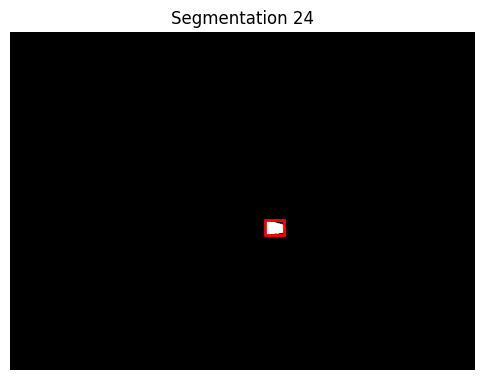

Segmentation 25 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 224
 - Bounding Box: [301, 328, 16, 15]
 - Predicted IOU: 0.8966742157936096
 - Point Coordinates: [[312.5, 336.46875]]
 - Stability Score: 0.969298243522644
 - Crop Box: [0, 0, 800, 582]



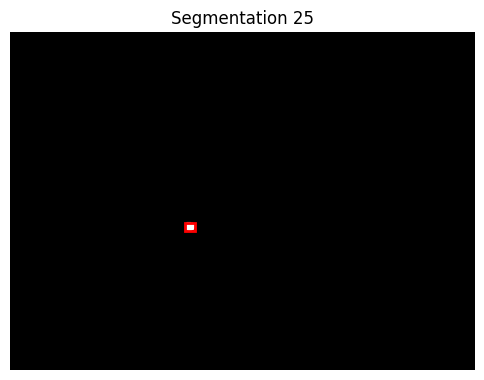

Segmentation 26 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 185
 - Bounding Box: [454, 362, 17, 16]
 - Predicted IOU: 0.8845255970954895
 - Point Coordinates: [[462.5, 372.84375]]
 - Stability Score: 0.9945945739746094
 - Crop Box: [0, 0, 800, 582]



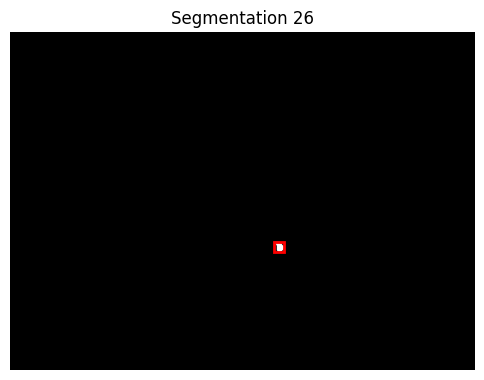

Segmentation 27 Info:
 - Segmentation Mask:
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
 - Area: 477
 - Bounding Box: [121, 439, 53, 15]
 - Predicted IOU: 0.8811061382293701
 - Point Coordinates: [[162.5, 445.59375]]
 - Stability Score: 0.9590163826942444
 - Crop Box: [0, 0, 800, 582]



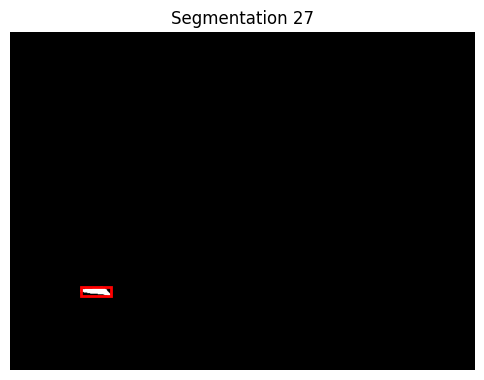

In [54]:
import matplotlib.pyplot as plt
import numpy as np


# display function
def display_segmentations(segmentations):
    for i, seg_info in enumerate(segmentations):
        print(f"Segmentation {i+1} Info:")
        print(f" - Segmentation Mask:\n{seg_info['segmentation']}")
        print(f" - Area: {seg_info['area']}")
        print(f" - Bounding Box: {seg_info['bbox']}")
        print(f" - Predicted IOU: {seg_info['predicted_iou']}")
        print(f" - Point Coordinates: {seg_info['point_coords']}")
        print(f" - Stability Score: {seg_info['stability_score']}")
        print(f" - Crop Box: {seg_info['crop_box']}")
        print("")

        # Create a binary image from the segmentation mask
        binary_mask = np.array(seg_info["segmentation"], dtype=np.uint8) * 255

        # Display the image and overlay the segmentation mask
        plt.figure(figsize=(6, 6))
        plt.imshow(binary_mask, cmap="gray")
        plt.title(f"Segmentation {i+1}")
        plt.axis("off")

        # Draw bounding box
        rect = plt.Rectangle(
            (seg_info["bbox"][0], seg_info["bbox"][1]),
            seg_info["bbox"][2],
            seg_info["bbox"][3],
            linewidth=2,
            edgecolor="r",
            facecolor="none",
        )
        plt.gca().add_patch(rect)

        plt.show()


# Call the function with your segmentation results
display_segmentations(ans)